Импорт необходимых библиотек

In [113]:
import numpy as np       
import pandas as pd               
import string            
import re                
from sklearn.feature_extraction.text import TfidfVectorizer                 
import gensim                                        
import gensim.downloader
from gensim.models import word2vec, KeyedVectors

In [114]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cpu'

In [80]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [115]:
goods = pd.read_csv('sample-data.csv')
goods.head()

,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


Предобработка данных

In [116]:
class ClearText(object):
    
    def __init__(self,pandas_series, symbols_to_delete : list, stop_words : list) -> None:
        
        self.pandas_series = pandas_series
        self.symbols_to_delete = symbols_to_delete
        self.stop_words = stop_words
        self.string_symbols = string.digits       
        
    # удаляем пунктуацию и символы
    def __remove_chars_from_text(self, text):
        return "".join([ch for ch in text if ch not in self.symbols_to_delete])

    def __remove_string_symbols(self, text):
         return "".join([ch for ch in text if ch not in self.string_symbols])

    # Удаляем все стоп слова из текста продукта
    def __clear_stop_words(self, text):
        return ' '.join([word for word in str(text).split() if word not in self.stop_words])


    # Удаляем  HTML-ссылки
    def __remove_urls(self, text):
        url_remove = re.compile(r'https?://\S+|www\.\S+')
        return url_remove.sub(r' ', text)
    
    # Удаляем URL-ссылки
    def __remove_html(self, text):
        html=re.compile(r'<.*?>')
        return html.sub(r' ',text)
    
    def get_clear_text(self):
        # Удаляем URL-ссылки
        self.pandas_series = self.pandas_series.apply(lambda x: self.__remove_urls(x))

        # Удаляем HTML-ссылки
        self.pandas_series = self.pandas_series.apply(lambda x: self.__remove_html(x))

        # нижний регистр
        self.pandas_series = self.pandas_series.apply(lambda x: x.lower())

        # Удаляем пунктуацию и спец-символы
        self.pandas_series = self.pandas_series.apply(lambda x: self.__remove_chars_from_text(x))

        # Удаляем цифры
        self.pandas_series = self.pandas_series.apply(lambda x: self.__remove_string_symbols(x))

        # Убираем лишние пробелы
        self.pandas_series = self.pandas_series.apply(lambda x: ' '.join(x.split()))
        
        # Убираем стоп-слова
        self.pandas_series = self.pandas_series.apply(lambda x: self.__clear_stop_words(x))
        
        return self.pandas_series
        


Перед тем как очищать текст, взглянем на пропущенные значения в dataset

<Axes: >

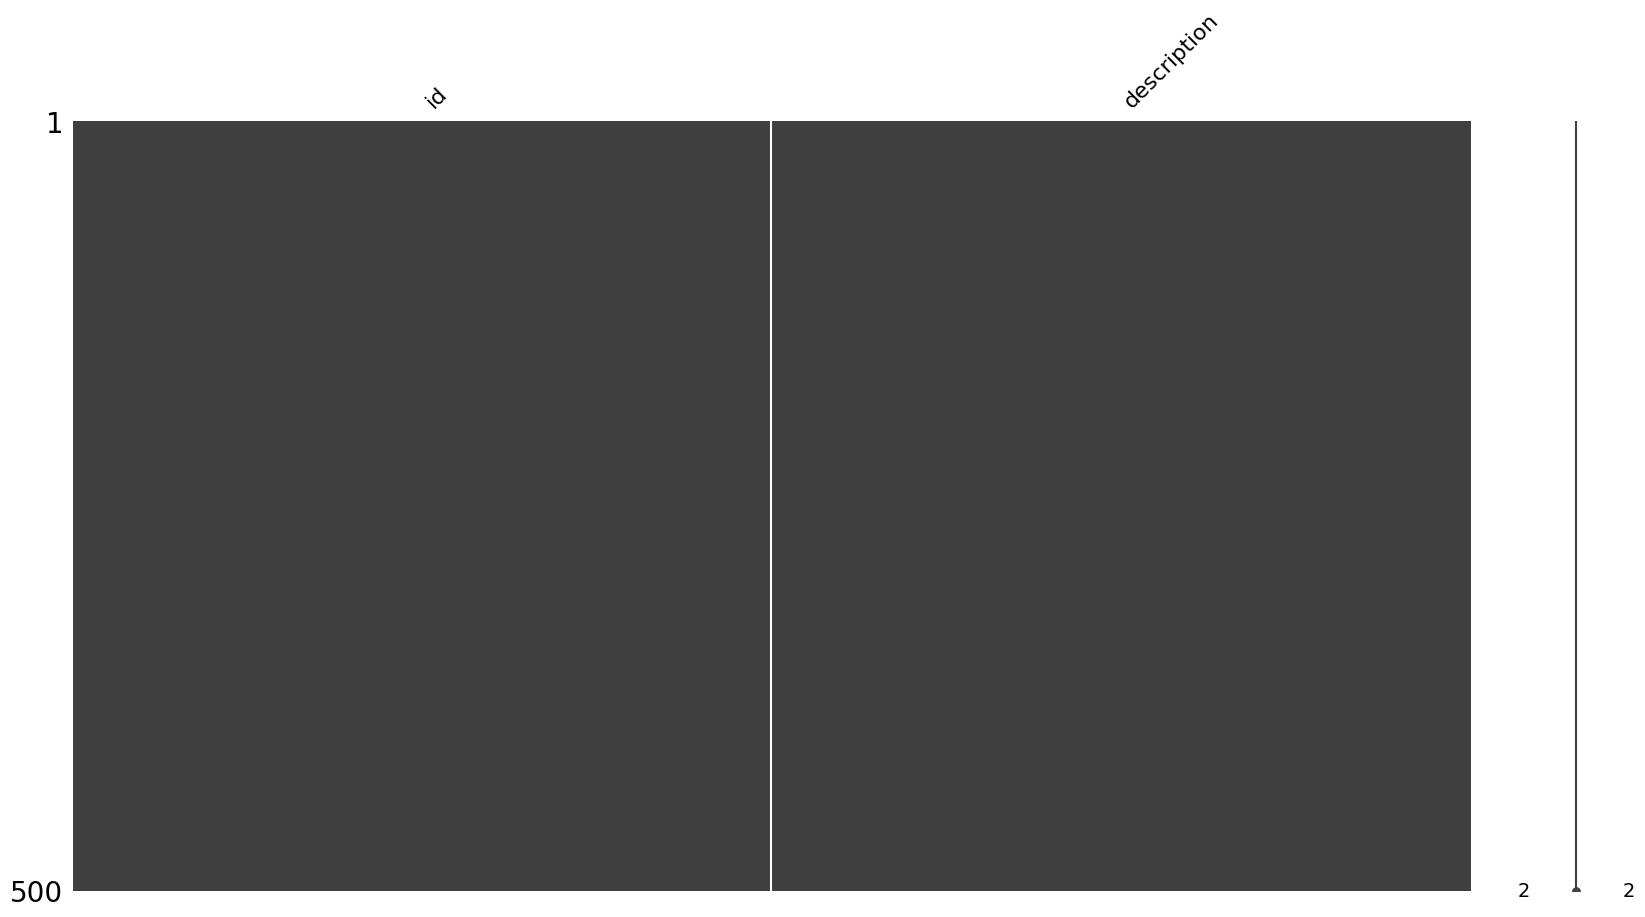

In [117]:
import missingno

missingno.matrix(goods, figsize=(20,10))

Пропущенных значений нет, значит мы можем приступать к очистке текста

In [118]:
import nltk
from nltk.corpus import stopwords  
nltk.download('stopwords')

stopwords_english = stopwords.words('english')
stopwords_english.extend(['g', 'oz'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Polina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [119]:
# создадим экземпляр класса
description = ClearText(goods['description'], string.punctuation, stopwords_english)

goods['description'] = description.get_clear_text()
goods.head()

,id,description
0,1,active classic boxers theres reason boxers cul...
1,2,active sport boxer briefs skinning glory requi...
2,3,active sport briefs superbreathable nofly brie...
3,4,alpine guide pants skin climb ice switch rock ...
4,5,alpine wind jkt high ridges steep ice anything...


Мы получили очищенный dataset

Используем TFIDF

In [120]:
from sklearn.metrics.pairwise import linear_kernel 

tfidf_vectorizer = TfidfVectorizer(binary=True, max_features=25000)

# Преобразуем массив очищенных текстов в матрицы TFIDF
tfidf_embedings = tfidf_vectorizer.fit_transform(goods['description'])


# Здесь linear kernel эквивалентно cosine_similarity  
cosine_similarities_tfidf = linear_kernel(tfidf_embedings, tfidf_embedings)

In [121]:
# Создадим функция для поиска id похожих товаров
def get_id_of_sim_goods(sim_matrix, item_id, num):

    index = goods.index[goods['id'] == item_id].tolist()[0] # Определяем индекс товара в матрице расстояний
    return sim_matrix[index].argsort()[:-(num+2):-1]

In [122]:
# Создаем csv файл, в котором для каждого id товара сформирован список из трех наиболее похожих на него товаров

def create_csv_sub(cosine_sim, name_of_file):

    sim_goods = pd.DataFrame()
    # ищем id 3 товаров похожих на товар текущего id
    for item in range(1, len(goods['description'])):
        
        item_similary_list = get_id_of_sim_goods(cosine_sim,item, 3).tolist()
        sim_goods = pd.concat([sim_goods, pd.DataFrame({'id': item_similary_list[0]+1, 'id_sim_goods': [item_similary_list[1:]]} ) ],ignore_index=True)

    sim_goods['id_sim_goods'] = sim_goods['id_sim_goods'].apply(lambda x : ','.join(str(item+1) for item in x))
    sim_goods.to_csv(name_of_file, index=False)

In [123]:
# output file tf-idf
create_csv_sub(cosine_similarities_tfidf, 'output_tf-idf.csv')

Используем WordToVec

In [125]:
import gensim.downloader
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Polina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
# создаем матрицу векторов с помощью word2vec
def create_embed_matrix(texts):
    
    embed_matrix = np.zeros((len(texts), glove_vectors.vector_size))
    for ind, text in enumerate(texts):
        mean_word2vec = np.zeros(glove_vectors.vector_size)
        num_words = 0

        for word in text:
            if word in glove_vectors.index_to_key:
                mean_word2vec += glove_vectors[word]
                num_words += 1
        embed_matrix[ind] = mean_word2vec/num_words

        embed_matrix[ind] = embed_matrix[ind]/np.sqrt(np.sum(embed_matrix[ind]**2)) 
    return embed_matrix

In [127]:
mean_word2vec_matrix = create_embed_matrix(goods['description'].values)

In [128]:
cosine_similarities_word2vec = linear_kernel(mean_word2vec_matrix, mean_word2vec_matrix)

In [129]:
# output file word2vec
create_csv_sub(cosine_similarities_word2vec, 'output_word2vec.csv')